# MNIST

## data

In [27]:
import qsvm.Qmapping as Q
import qsvm.data_function as df
import numpy as np
from qsvm.qsvm import Pca,QSVM

In [28]:
from scipy.io import loadmat
import random

f = open('./Datasets/mini.json', 'r') 
tg = json.load(f)
f.close()
traindata = np.array(tg['train']['data'])
trainlabels = np.array(tg['train']['label'])
testdata = np.array(tg['test']['data'])
testlabels = np.array(tg['test']['label'])


print(traindata.shape)
print(trainlabels.shape)
print(testdata.shape)
print(testlabels.shape)

(400, 784)
(400,)
(200, 784)
(200,)


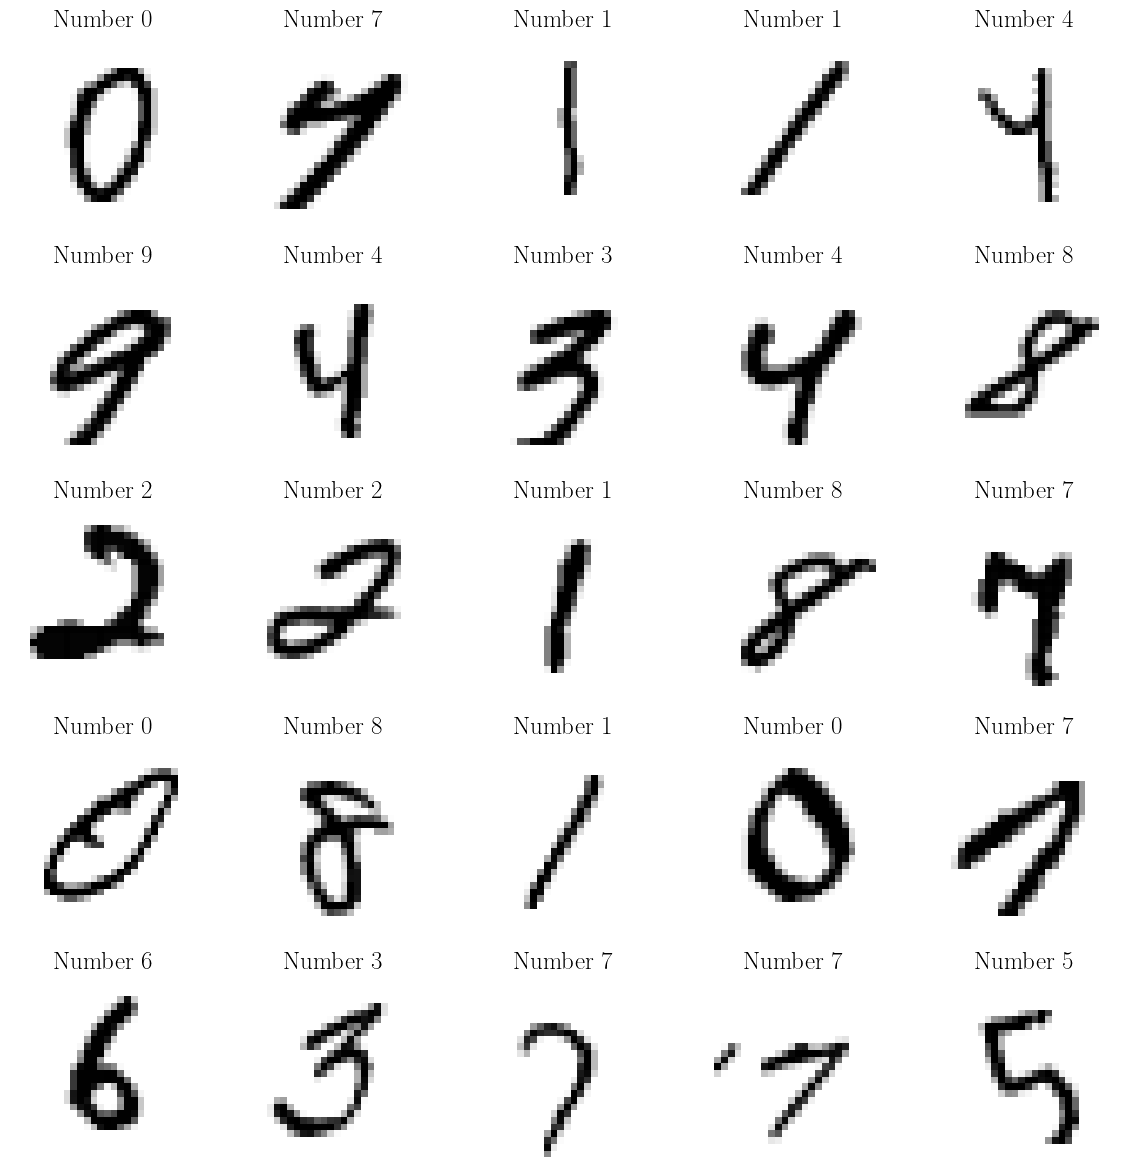

In [29]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, axs = plt.subplots(5, 5, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
  ax.imshow(traindata[i].reshape((28, 28)), cmap=cm.gray_r)
  ax.axis('off')
  ax.set_title('Number {}'.format(trainlabels[i]))

## Data pre-processing

In [30]:
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler

### PCA

In [31]:
pca=Pca(PCA_n=10,StandardizeOrNot=False,sklearnPCA=True)

In [32]:
pca.fitting(traindata)
svm_tr_data=pca.transform(traindata)
svm_te_data=pca.transform(testdata)

# Renormalize each feature
svm_tr_data=pca.Renormalize_Each_Feature(svm_tr_data,Norm=np.pi/2,status="train")
svm_te_data=pca.Renormalize_Each_Feature(svm_te_data,Norm=np.pi/2)

In [33]:
len(svm_tr_data)

400

## Construct Quantum Kernal

In [34]:
import time

In [35]:
qsvm=QSVM(task='svc')

In [36]:
start_time = time.time()
tr_kernel=qsvm.get_kernel(svm_tr_data,tier=1,method="analog+digital", op="x")
te_kernel=qsvm.get_kernel(svm_te_data,status="test",tier=1,method="analog+digital", op="x")
end_time=time.time()

In [37]:
cost_time=end_time-start_time

In [45]:
print(cost_time)

12.39780306816101


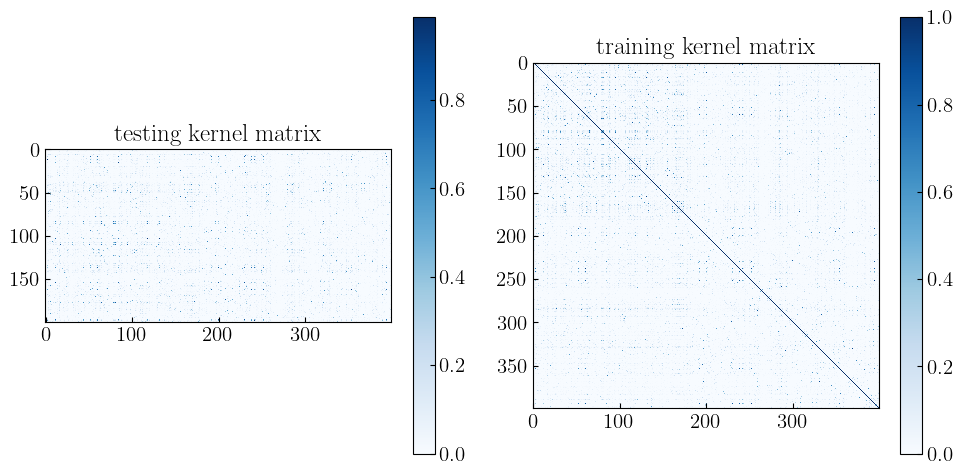

In [38]:
Q.show_kmatrix(train = tr_kernel , test = te_kernel,name = "")

## Supported Vector Machine

In [66]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import linear_kernel,rbf_kernel

### Linear kernel

In [70]:
_k_linear_tr = linear_kernel(svm_tr_data)
_k_linear_te = linear_kernel(svm_te_data,svm_tr_data)

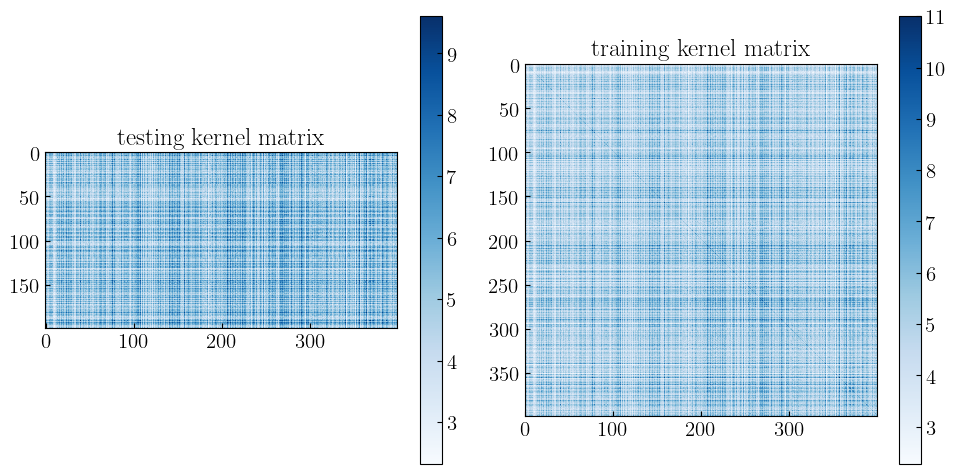

In [71]:
Q.show_kmatrix(train = _k_linear_tr , test = _k_linear_te,name = "")

In [72]:
clf = SVC(kernel="precomputed",C=1.0)
clf.fit(_k_linear_tr, trainlabels)
y_pred = clf.predict(_k_linear_te)
accuracy = np.mean(y_pred == testlabels)
print("Accuracy:", accuracy)

Accuracy: 0.81


In [73]:
clf = SVC(kernel="linear",C=1.0)
clf.fit(svm_tr_data, trainlabels)
y_pred = clf.predict(svm_te_data)
accuracy = np.mean(y_pred == testlabels)
print("Accuracy:", accuracy)

Accuracy: 0.81


### rbf kernel

In [80]:
_k_rbf_tr = rbf_kernel(svm_tr_data,gamma=1/(10*svm_tr_data.var()))
_k_rbf_te = rbf_kernel(svm_te_data,svm_tr_data,gamma=1/(10*svm_tr_data.var()))

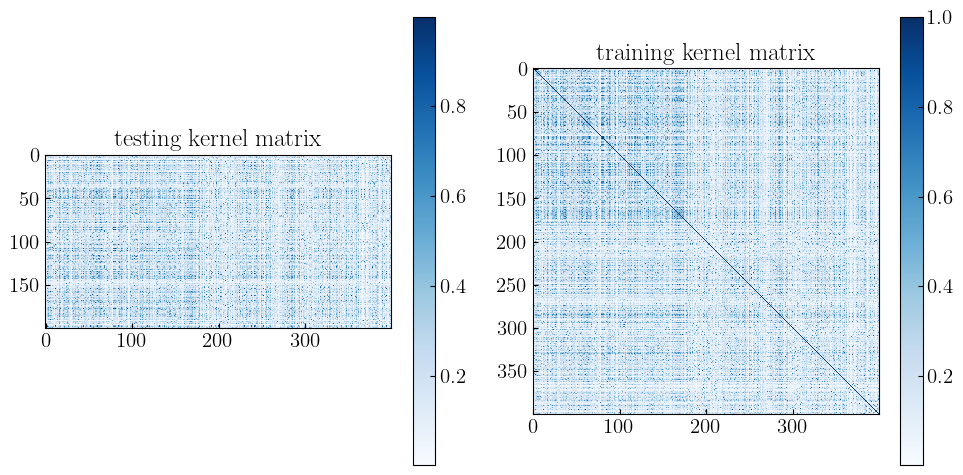

In [81]:
Q.show_kmatrix(train = _k_rbf_tr , test = _k_rbf_te,name = "")

In [82]:
clf = SVC(kernel="precomputed",C=1)
clf.fit(_k_rbf_tr, trainlabels)
y_pred = clf.predict(_k_rbf_te)
accuracy = np.mean(y_pred == testlabels)
print("C={},Accuracy:{}".format(c,accuracy))
print("\n")

C=10.0,Accuracy:0.855




In [48]:
C_list = [0.1, 0.5, 1.0, 5.0, 10.0]
for c in C_list:
  clf = SVC(kernel="rbf",C=c)
  clf.fit(svm_tr_data, trainlabels)
  y_pred = clf.predict(svm_te_data)
  accuracy = np.mean(y_pred == testlabels)
  print("C={},Accuracy:{}".format(c,accuracy))
  print("\n")
#C represents the penalty coefficient for misclassification,A larger value of C will make the model strictly classify all samples correctly.
#C=10 give me the best accurarcy

C=0.1,Accuracy:0.685


C=0.5,Accuracy:0.85


C=1.0,Accuracy:0.855


C=5.0,Accuracy:0.855


C=10.0,Accuracy:0.875




### quantum kernel

In [53]:
clf = SVC(kernel="precomputed",C=1)
clf.fit(tr_kernel, trainlabels)

SVC(C=1, kernel='precomputed')

In [54]:
y_pred = clf.predict(te_kernel)
accuracy = np.mean(y_pred == testlabels)
print("Accuracy:", accuracy)

Accuracy: 0.84
